### Industrial Organization - Assignment 3
##### Luciano Fabio Busatto Venturim
##### 1st Quarter - 2022
##### EPGE/FGV

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize

Loading the data

In [2]:
data = pd.read_csv('../data/io_assignment3_data.txt')

In [3]:
data.head()

,Bid1,Bid2,Bid3,Reject
0,33.35,18.54,22.79,1
1,17.14,32.94,18.93,0
2,12.27,23.47,12.23,0
3,31.18,12.75,17.38,0
4,19.82,23.93,28.11,0


### Question 2

In [4]:
nbids = 3*len(data)
bids = data[['Bid1','Bid2','Bid3']].values.reshape((nbids,))

In [5]:
# the bandwidth from the Silverman's rule of thumb

bw = 1.06*np.std(bids)*(nbids)**(-1/5)

In [6]:
bw

2.2592581079126277

In [7]:
def normal_kernel_pdf(ev_points, data, bandw):
    """
    This function estimates a PDF using a normal kernel at every point in ev_points using data and the specified bandwidth bandw
    """
    
    ev_points_len = len(ev_points)
    data_len = len(data)
    
    ev_points_rep = np.tile(ev_points, (data_len,1))
    data_rep = np.tile(data, (ev_points_len,1)).T
    
    z = norm.pdf((ev_points_rep - data_rep)/bandw)
    
    den = np.sum(z, axis = 0)/(data_len*bandw)
    
    return(den)

In [8]:
def normal_kernel_cdf(ev_points, data, bandw):
    """
    This function estimates a CDF using a normal kernel at every point in ev_points using data and the specified bandwidth bandw
    """    
    
    ev_points_len = len(ev_points)
    data_len = len(data)
    
    ev_points_rep = np.tile(ev_points, (data_len,1))
    data_rep = np.tile(data, (ev_points_len,1)).T
    
    z = norm.cdf((ev_points_rep - data_rep)/bandw)
    
    den = np.sum(z, axis = 0)/(data_len)
    
    return(den)

In [9]:
# the pdf and cdf of bids, B and B'
pdf_bids = normal_kernel_pdf(bids,bids,bw)
cdf_bids = normal_kernel_cdf(bids,bids,bw)

In [10]:
reject = data['Reject'].values
bid_max = data[['Bid1','Bid2','Bid3']].max(axis = 1).values

In [11]:
def loglikelihood_h(par):
    """
    This function evaluates the loglikelihood criterion function for a given (2,) array of parameters, assuming that
    the reservation price follows a log-normal distribution.
    """
    
    z = norm.cdf((np.log(bid_max)-par[0])/par[1])
    ll = sum(reject*np.log(1-z)+(1-reject)*np.log(z))
    
    return(-ll)

In [12]:
ml_par = minimize(loglikelihood_h, x0 = np.array([0,1]), method='BFGS').x

In [13]:
# the estimated parameters using maximum likelihood
ml_par

array([0.9493334 , 2.74151857])

In [14]:
# the reservation price pdf and cdf, H' and H, using the parameters estimated by ML assuming a log-normal distribution.
pdf_res_price = norm.pdf((np.log(bids)-ml_par[0])/ml_par[1])*(1/(ml_par[1]*bids))
cdf_res_price = norm.cdf((np.log(bids)-ml_par[0])/ml_par[1])

Now, we can estimate the private values using the estimated pdfs and cdfs, and then estimate the pdf of the private values.

In [15]:
# the distribution G
pdf_max_bids = 2*cdf_bids*pdf_bids
cdf_max_bids = cdf_bids**2

In [16]:
# the estimated private values
v = bids + (cdf_max_bids*cdf_res_price)/(pdf_max_bids*cdf_res_price+cdf_max_bids*pdf_res_price)

In [17]:
# Bandwidth from Silverman's rule of thumb for the estimation of the pdf of private values
bw_v = 1.06*np.std(v)*(len(v))**(-1/5)

In [18]:
x = np.linspace(min(v),max(v),2000)

In [19]:
pdf_v = normal_kernel_pdf(x,v,bw_v)

Below, I show the estimated pdf of private values.

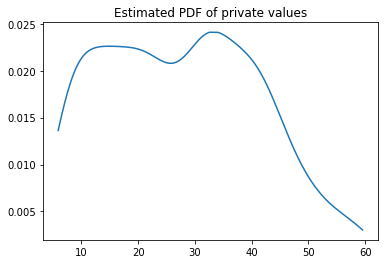

In [20]:
plt.plot(x[(pdf_v > np.quantile(pdf_v, q = 0.025))&(pdf_v < np.quantile(pdf_v, q = 0.975))],
         pdf_v[(pdf_v > np.quantile(pdf_v, q = 0.025))&(pdf_v < np.quantile(pdf_v, q = 0.975))])
plt.title('Estimated PDF of private values');

### Question 3

In [21]:
r_grid_len = 200
r_grid = np.linspace(4,32,r_grid_len)

# dx is used in the approximation of the integral
dr = (32-4)/r_grid_len

# distributions
pdf_r = normal_kernel_pdf(r_grid,v,bw_v)
cdf_r = normal_kernel_cdf(r_grid,v,bw_v) 

# trimmed distributions
cdf_r = cdf_r[(pdf_r > np.quantile(pdf_r, q = 0.025))&(pdf_r < np.quantile(pdf_r, q = 0.975))]
r_grid = r_grid[(pdf_r > np.quantile(pdf_r, q = 0.025))&(pdf_r < np.quantile(pdf_r, q = 0.975))]
pdf_r = pdf_r[(pdf_r > np.quantile(pdf_r, q = 0.025))&(pdf_r < np.quantile(pdf_r, q = 0.975))]

# vector of revenues
revenue = np.zeros(len(r_grid))

# the arrays next_. are used to estimate the integral
for i, r in enumerate(r_grid):
    next_grid = r_grid[(r_grid >= r)&(r_grid <= max(v))]
    next_pdf = pdf_r[(r_grid >= r)&(r_grid <= max(v))]
    next_cdf = cdf_r[(r_grid >= r)&(r_grid <= max(v))]
    revenue[i] = 3*(r*(1-cdf_r[i])*(cdf_r[i]**2)*(3-2*cdf_r[i]) +
                    6*sum(next_grid*((1-next_cdf)**2)*next_cdf*next_pdf)*dr)

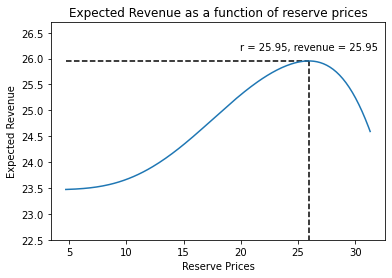

In [22]:
plt.plot(r_grid,revenue)
plt.vlines(r_grid[revenue == max(revenue)], min(revenue)-1,max(revenue),linestyles='dashed',color='k')
plt.hlines(max(revenue),min(r_grid),(r_grid[revenue == max(revenue)]),linestyles='dashed',color='k')
plt.annotate(f'r = {r_grid[revenue == max(revenue)][0]:.2f}, revenue = {max(revenue):.2f}', 
             xy = (r_grid[revenue == max(revenue)]-6, max(revenue)+0.2))
plt.ylim((22.5,26.7))
plt.xlabel('Reserve Prices')
plt.ylabel('Expected Revenue')
plt.title('Expected Revenue as a function of reserve prices');